# MNIST OCR Model
##### Taken from [here](https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627)
##### This multi-digit mnist ocr uses our original MNIST classifier model on multi digit images that we split into single digit images and classify seperately. In order to use this notebook, train the model in [this](https://colab.research.google.com/drive/15_s6DFZJZFFgFvhzl0Xkm7-uGurq288N?usp=sharing#) notebook, save it, and load it in here.

## Initial setup

In [ ]:
# imports and utils
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

import torchvision
from torchvision import datasets, transforms
from google.colab import drive

drive.mount('/content/gdrive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.'''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Mounted at /content/gdrive


In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('gdrive/MyDrive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('gdrive/MyDrive/mnist/MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create (or Load) Multi-Digit Dataset

In [ ]:
class NumberDataset(torchvision.datasets.MNIST) :

  def __init__(self, num_to_generate=120000, num_of_digits=4, im_width=28, im_height=28, train=True, download=True) :
    """
    Args : 
      num_of_digits (int) : the number of digits in each number
      im_width (int) : the width of a single digit image
      im_height (int) : the height of a single digit image
      train (bool) : if True create the images from the training set
      download (bool) : if True downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
    """

    self.transform = transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5,),(0.5,)),
    ])
    self.data = torch.utils.data.DataLoader(
        datasets.MNIST('gdrive/MyDrive/mnist/MNIST_data/', train=train, download=download, 
                                  transform=self.transform),
                                  batch_size=4, shuffle=True)
    
    self.res = []

    for i in range(num_to_generate):
      if ((i % 1000) == 0) : 
        print("Done {} numbers".format(i))
      digits, vals = next(iter(self.data))
      target = 0
      image = torch.transpose(torch.reshape(torch.transpose(digits, 2,3), (1, num_of_digits * im_width, im_height)), 1,2)
      for j in range(num_of_digits): 
        target = target + vals[j] * pow(10, num_of_digits-1-j)
      self.res.append((image, target))

In [ ]:
num_of_digits = 4
im_width = 28
im_height = 28
batch_size_train = 1000
batch_size_test = 600
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_data = NumberDataset(num_to_generate=batch_size_train, num_of_digits=num_of_digits, im_width=im_width, im_height=im_height).res
train_size = len(train_data)

print("Done proccessing training set, got {} numbers".format(train_size))

test_data = NumberDataset(num_to_generate=batch_size_test, num_of_digits=num_of_digits, im_width=im_width, im_height=im_height, train=False).res
test_size = len(test_data)
print("Done proccessing test set, got {} numbers".format(test_size))

In [ ]:
# Visualize the Data Set
fig2, axes = plt.subplots(3,3)
fig2.tight_layout()
for i in range(9):
  sub = axes[int(i/3), i%3]
  sub.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  sub.set_title("Ground Truth: {}".format(train_data[i][1])) 
  sub.set_xticks([])
  sub.set_yticks([])

In [ ]:
torch.save(train_data, 'gdrive/MyDrive/mnist/4_digit_model/mnist_4_digit_train_data')
torch.save(test_data, 'gdrive/MyDrive/mnist/mnist_4_digit_test_data')

In [ ]:
train_data = torch.load('gdrive/MyDrive/mnist/mnist_4_digit_train_data')
test_data = torch.load('gdrive/MyDrive/mnist/mnist_4_digit_test_data')

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

## Load OCR model - start here if you want to load an existing model


In [ ]:
# Load model
model = torch.load('gdrive/My Drive/mnist/mnist_ocr_model')

## Evaluate the model

In [ ]:
def OCR(num_digits: int, valloader):
  images, labels = next(iter(valloader))
  
  figure = plt.figure()
  plt.axis('off')
  plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

  # Split the n-digit image into n same equal parts
  for i in range(num_digits):
    img = images[0].view(28, 28 * num_digits)
    single_digit = img[:, (i)*28:(i+1)*28]
    single_digit_reshaped = single_digit.reshape(1, 28*28)

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(single_digit_reshaped)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(single_digit_reshaped.view(1, 28, 28), ps)

RuntimeError: ignored

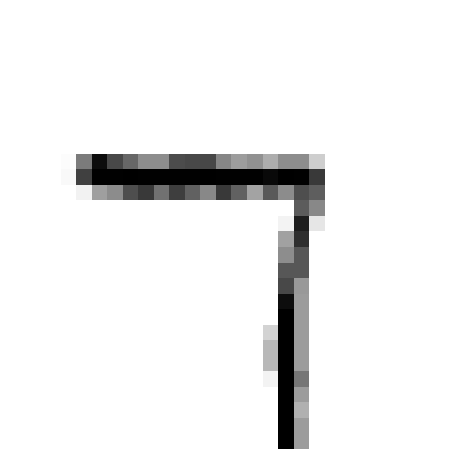

In [ ]:
OCR(num_digits=4, valloader=valloader)